In [1]:
import  gensim
archivoModelo = 'Vectores.w2v'

C:\Users\joax\Anaconda2\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
archivoComentarios = 'SoloTextos.txt'
sentences = gensim.models.word2vec.Text8Corpus(archivoComentarios)


In [4]:
import multiprocessing

#Dimensionality of the resulting word vectors
num_features = 128
#Minimum word count threshold
min_word_count = 3
#Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()
#Context window length
context_size = 5
#Seed for the RNG, to make the result reproducible
seed = 1

modelo = gensim.models.word2vec.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context_size)

modelo.build_vocab(sentences=sentences)
print("Vocabulario construido")
print("Tamaño de vocabulario de Word2Vec: ", len(modelo.wv.vocab))
#Start training the model
print("Inicio entrenamiento")
modelo.train(sentences=sentences,total_examples=modelo.corpus_count, epochs=30)
print("Fin entrenamiento")
modelo.save(archivoModelo)
print("Modelo guardado")

Vocabulario construido
Tamaño de vocabulario de Word2Vec:  4446
Inicio entrenamiento
Fin entrenamiento
Modelo guardado


In [6]:
import numpy as np

modelo = gensim.models.word2vec.Word2Vec.load(archivoModelo)  # you can continue training with the loaded model!
count = 10000
word_vectors_matrix = np.ndarray(shape=(count, num_features), dtype='float64')
word_list = []
i = 0
for word in modelo.wv.vocab:
    word_vectors_matrix[i] = modelo[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (10000, 128)


C:\Users\joax\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

In [7]:
import pandas as pd
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")
points.head((10))

Points DataFrame built


,word,x,y
0,salgo,-8.392507,6.924228
1,de,-1.506186,8.935769
2,#veotv,-1.869771,13.612466
3,que,-1.091605,9.702168
4,día,-19.335794,37.245392
5,más,-1.712399,10.058319
6,@pauladelasheras,3.069117,15.795995
7,no,-0.908894,9.690550
8,te,-1.711293,10.051030
9,ayudar,0.709292,-0.630724


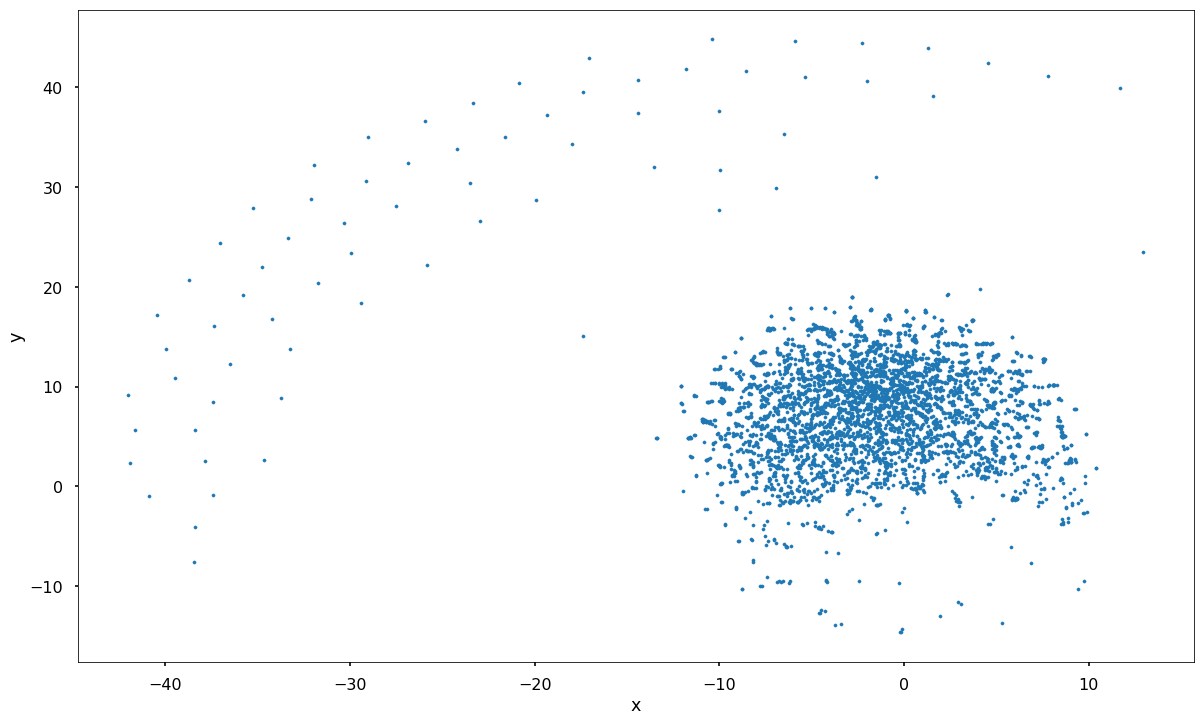

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")

points.plot.scatter("x", "y", s=10, figsize=(20, 12))

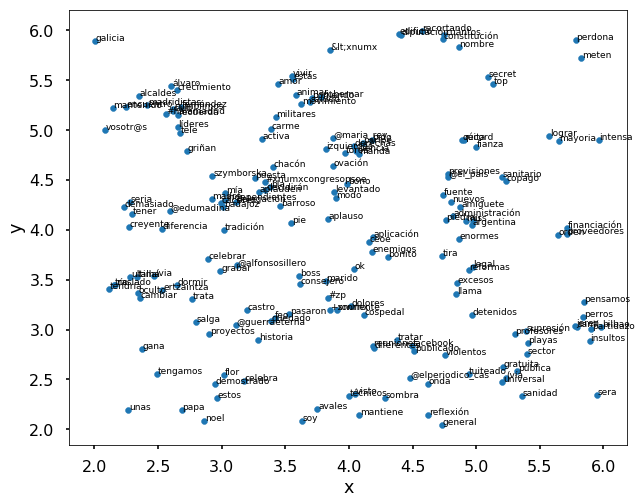

In [20]:
def plot_region (x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=9)
    
plot_region(x_bounds=(2, 6), y_bounds=(2, 6))

In [24]:
modelo.most_similar("feliz")

C:\Users\joax\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('navidad', 0.5633161067962646),
 ('igualmente', 0.5382398366928101),
 ('nochevieja', 0.447253942489624),
 ('felices', 0.44263216853141785),
 ('hermanas', 0.4403750002384186),
 ('#herenciapsoe', 0.4187315106391907),
 ('gym', 0.41700315475463867),
 ('chicas', 0.40860629081726074),
 ('regalos', 0.4009578227996826),
 ('@alejandramarpor', 0.4007263779640198)]